In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
try:
    import torch  # type: ignore[import]
    import torch.nn as nn  # type: ignore[import]
    from torch.utils.data import TensorDataset, DataLoader, random_split  # type: ignore[import]
except ImportError as exc:
    raise ImportError(
        "PyTorch is required for this notebook. Please install torch."
    ) from exc
try:
    from sklearn.preprocessing import MinMaxScaler  # type: ignore[import]
except ImportError as exc:
    raise ImportError(
        "scikit-learn is required for this notebook. Please install scikit-learn."
    ) from exc

torch.manual_seed(42)

import sys
root_dir = os.path.abspath("..")
if root_dir not in sys.path:
    sys.path.append(root_dir)
# print("Project root in sys.path:", root_dir)

from src.config import (
    CMAPSS_DATASETS,
    MAX_RUL,
    SEQUENCE_LENGTH,
    HIDDEN_SIZE,
    NUM_LAYERS,
    OUTPUT_SIZE,
    LEARNING_RATE,
    NUM_EPOCHS,
    GLOBAL_FEATURE_COLS,
    GLOBAL_DROP_COLS 
)

from src.data_loading import load_cmapps_subset
from src.additional_features import create_physical_features
from src.world_model_training import train_world_model_global

In [38]:
import importlib
import src.world_model_training as wmt

importlib.reload(wmt)

from src.data_loading import load_cmapps_global
from src.additional_features import create_physical_features
from src.config import GLOBAL_FEATURE_COLS, GLOBAL_DROP_COLS
from src.world_model_training import train_world_model_global_multitask

# 1) globale Trainingsdaten bauen (Pseudo-Code, an deine Signaturen anpassen)
dfs = []
for fd_id in ["FD001"]: #, "FD002", "FD003", "FD004"
    df_train, _, _ = load_cmapps_subset(fd_id)  # ggf. add_rul=True etc.
    df_train = create_physical_features(df_train)
    df_train["FD_ID"] = fd_id
    dfs.append(df_train)

df_train_global = pd.concat(dfs, ignore_index=True)

# 2) Featureliste definieren (wie beim globalen LSTM)
numeric_cols = df_train_global[GLOBAL_FEATURE_COLS].select_dtypes(
    include=["number"]
).columns.tolist()
feature_cols = numeric_cols

# 5) Train World Model
model_world_mt, hist_world_mt = train_world_model_global_multitask(
    df_train_global=df_train_global,
    feature_cols=feature_cols,
    past_len=30,
    horizon=20,
    hidden_size=64,
    num_layers=2,
    dropout=0.1,
    batch_size=128,
    num_epochs=20,
    lr=1e-3,
    val_split=0.1,
    lambda_traj=1.0,
    lambda_eol=2.0,
    lambda_bias=0.1,
    # lambda_nasa=0.05,
    early_stopping_patience=5,
    checkpoint_dir="results/world_model_multitask",
)


New columns successfully added. Current number of columns: 32
   Effizienz_HPC_Proxy  EGT_Drift  Fan_HPC_Ratio  RUL
0             0.941013        0.2       0.403737  125
1             0.943169        0.2       0.403406  125
2             0.942554       -1.8       0.404505  125
3             0.943025        0.2       0.405834  125
4             0.942581        1.2       0.405831  125
[WorldModel-MT] Epoch 1/20 - train: 24557.1414, val: 21742.1549, traj: 7014.0304 (350.7015/step), eol: 7093.4872, bias: 5411.502983, nasa: 1121.8033
--> New best multitask model at epoch 1 with val_loss=21742.1549
[WorldModel-MT] Epoch 2/20 - train: 19495.8279, val: 17743.5919, traj: 5735.7880 (286.7894/step), eol: 5798.0962, bias: 4116.111813, nasa: 1004.0723
--> New best multitask model at epoch 2 with val_loss=17743.5919
[WorldModel-MT] Epoch 3/20 - train: 16002.6235, val: 14624.3323, traj: 4736.9882 (236.8494/step), eol: 4788.3536, bias: 3106.368636, nasa: 577.5016
--> New best multitask model at epoch 

In [39]:
# --- GLOBAL TEST ---
dfs_test = []

for fd_id in ["FD001"]:  #"FD002", "FD003", "FD004"
    df_train, df_test, rul_test = load_cmapps_subset(fd_id)

    # 1) MaxTime pro Unit im TEST berechnen
    max_cycles = (
        df_test.groupby("UnitNumber")["TimeInCycles"]
        .max()
        .rename("MaxTime")
        .reset_index()
    )
    df_test = df_test.merge(max_cycles, on="UnitNumber", how="left")

    # 2) RUL_last pro Unit aus rul_test bauen
    #    Wir gehen davon aus: rul_test ist in der Reihenfolge Unit 1..N
    units = (
        df_test[["UnitNumber"]]
        .drop_duplicates()
        .sort_values("UnitNumber")
        .reset_index(drop=True)
    )
    rul_df = pd.DataFrame({
        "UnitNumber": units["UnitNumber"].values,
        "RUL_last": rul_test.reshape(-1),
    })

    df_test = df_test.merge(rul_df, on="UnitNumber", how="left")

    # 3) RUL(t) = RUL_last + (MaxTime - TimeInCycles)
    df_test["RUL"] = df_test["RUL_last"] + (df_test["MaxTime"] - df_test["TimeInCycles"])

    # 4) Optional: RUL clamping wie im Training
    df_test["RUL"] = df_test["RUL"].clip(upper=MAX_RUL)

    # 5) Physikfeatures ergänzen
    df_test = create_physical_features(df_test)

    # 6) FD_ID hinzufügen
    df_test["FD_ID"] = fd_id

    dfs_test.append(df_test)

df_test_global = pd.concat(dfs_test, ignore_index=True)

print("df_test_global columns:", df_test_global.columns)
print(df_test_global[["FD_ID", "UnitNumber", "TimeInCycles", "MaxTime", "RUL"]].head())

import importlib
import src.world_model_training as wmt

importlib.reload(wmt)

from src.world_model_training import evaluate_world_model_eol

eol_metrics = evaluate_world_model_eol(
    model=model_world_mt,
    df_global_test=df_test_global,
    feature_cols=feature_cols,
    past_len=30,   # konsistent mit deinem LSTM
)

print("EOL metrics (World Model, literature-style):")
for k, v in eol_metrics.items():
    print(f"{k}: {v}")


New columns successfully added. Current number of columns: 33
   Effizienz_HPC_Proxy  EGT_Drift  Fan_HPC_Ratio    RUL
0             0.941903        0.3       0.405617  125.0
1             0.941083        1.3       0.403985  125.0
2             0.941997        1.3       0.404842  125.0
3             0.941000       -0.7       0.405550  125.0
4             0.942237       -1.7       0.404810  125.0
df_test_global columns: Index(['UnitNumber', 'TimeInCycles', 'Setting1', 'Setting2', 'Setting3',
       'Sensor1', 'Sensor2', 'Sensor3', 'Sensor4', 'Sensor5', 'Sensor6',
       'Sensor7', 'Sensor8', 'Sensor9', 'Sensor10', 'Sensor11', 'Sensor12',
       'Sensor13', 'Sensor14', 'Sensor15', 'Sensor16', 'Sensor17', 'Sensor18',
       'Sensor19', 'Sensor20', 'Sensor21', 'ConditionID', 'MaxTime',
       'RUL_last', 'RUL', 'Effizienz_HPC_Proxy', 'EGT_Drift', 'Fan_HPC_Ratio',
       'FD_ID'],
      dtype='object')
   FD_ID  UnitNumber  TimeInCycles  MaxTime    RUL
0  FD001           1             1     

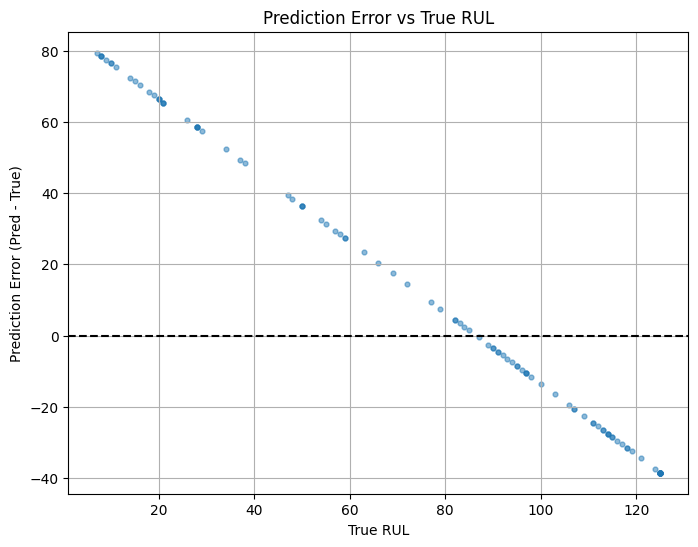

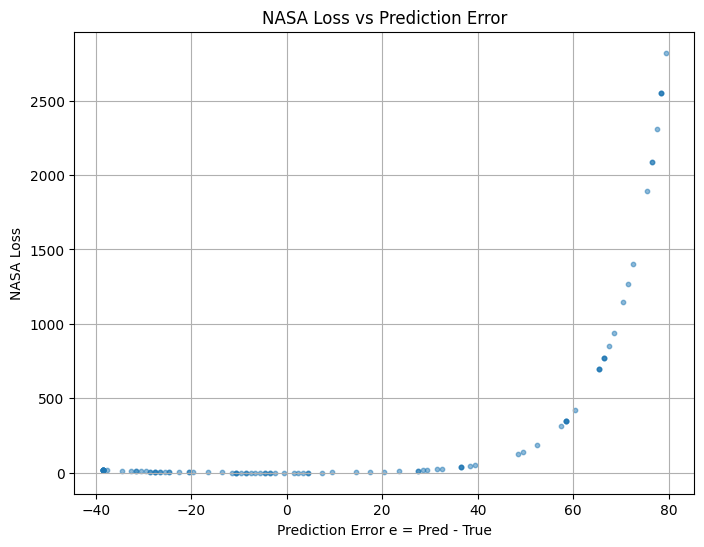

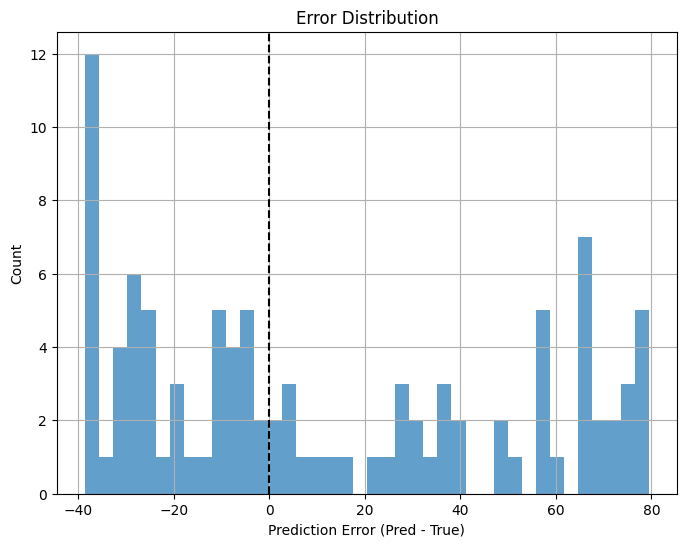

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Extract results_df from eol_metrics if available
if 'eol_metrics' in globals() and 'results_df' in eol_metrics:
    results_df = eol_metrics["results_df"]
else:
    raise ValueError("eol_metrics not found. Please run the evaluation first (Cell 2).")

true_rul = results_df["true_rul"].values
pred_rul = results_df["pred_rul"].values
errors = pred_rul - true_rul

plt.figure(figsize=(8,6))
plt.scatter(true_rul, errors, alpha=0.5, s=12)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel("True RUL")
plt.ylabel("Prediction Error (Pred - True)")
plt.title("Prediction Error vs True RUL")
plt.grid(True)
plt.show()

def nasa_loss(e):
    if e >= 0:
        return np.exp(e / 10.0) - 1.0
    else:
        return np.exp(-e / 13.0) - 1.0

errors = pred_rul - true_rul
nasa_values = np.array([nasa_loss(e) for e in errors])

plt.figure(figsize=(8,6))
plt.scatter(errors, nasa_values, alpha=0.5, s=10)
plt.xlabel("Prediction Error e = Pred - True")
plt.ylabel("NASA Loss")
plt.title("NASA Loss vs Prediction Error")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
plt.hist(errors, bins=40, alpha=0.7)
plt.axvline(0, color='k', linestyle='--')
plt.xlabel("Prediction Error (Pred - True)")
plt.ylabel("Count")
plt.title("Error Distribution")
plt.grid(True)
plt.show()



In [29]:
import numpy as np
import pandas as pd

# Falls noch nicht geschehen:
# results_df = pd.DataFrame({"true_rul": true_rul, "pred_rul": pred_rul})

true_rul = results_df["true_rul"].values.astype(float)
pred_rul = results_df["pred_rul"].values.astype(float)

# 1. Lineare Regression: true ≈ alpha * pred + beta
alpha, beta = np.polyfit(pred_rul, true_rul, deg=1)

print(f"Kalibrierung: true ≈ {alpha:.4f} * pred + {beta:.4f}")


Kalibrierung: true ≈ 0.4365 * pred + 37.2250


C:\Users\rober\AppData\Local\Temp\ipykernel_13180\4055109382.py:11: RankWarning: Polyfit may be poorly conditioned
  alpha, beta = np.polyfit(pred_rul, true_rul, deg=1)


In [30]:
MAX_RUL = 125  # falls du in FD001 mit 125 clampst

pred_rul_calib = alpha * pred_rul + beta

# Optional: auf physikalisch sinnvolle Grenzen begrenzen
pred_rul_calib_clipped = np.clip(pred_rul_calib, 0, MAX_RUL)

results_df["pred_rul_calib"] = pred_rul_calib
results_df["pred_rul_calib_clipped"] = pred_rul_calib_clipped


In [31]:
def compute_basic_metrics(y_true, y_pred):
    errors = y_pred - y_true
    mse = np.mean(errors**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(errors))
    bias = np.mean(errors)
    return mse, rmse, mae, bias, errors

def nasa_loss_from_errors(errors):
    # NASA/PHM08 Score pro Sample
    loss = np.where(
        errors >= 0,
        np.exp(errors / 10.0) - 1.0,
        np.exp(-errors / 13.0) - 1.0,
    )
    return loss


In [32]:
# A) Original (zur Kontrolle)
mse_orig, rmse_orig, mae_orig, bias_orig, errors_orig = compute_basic_metrics(true_rul, pred_rul)
nasa_orig = nasa_loss_from_errors(errors_orig)
print("== Original ==")
print(f"MSE:  {mse_orig:.3f}")
print(f"RMSE: {rmse_orig:.3f}")
print(f"MAE:  {mae_orig:.3f}")
print(f"Bias: {bias_orig:.3f}")
print(f"NASA mean: {nasa_orig.mean():.3f}")

# B) Kalibriert (ungeclippt)
mse_cal, rmse_cal, mae_cal, bias_cal, errors_cal = compute_basic_metrics(true_rul, pred_rul_calib)
nasa_cal = nasa_loss_from_errors(errors_cal)
print("\n== Kalibriert (ungeclippt) ==")
print(f"MSE:  {mse_cal:.3f}")
print(f"RMSE: {rmse_cal:.3f}")
print(f"MAE:  {mae_cal:.3f}")
print(f"Bias: {bias_cal:.3f}")
print(f"NASA mean: {nasa_cal.mean():.3f}")

# C) Kalibriert + geclippt
mse_cal_c, rmse_cal_c, mae_cal_c, bias_cal_c, errors_cal_c = compute_basic_metrics(true_rul, pred_rul_calib_clipped)
nasa_cal_c = nasa_loss_from_errors(errors_cal_c)
print("\n== Kalibriert + geclippt [0, MAX_RUL] ==")
print(f"MSE:  {mse_cal_c:.3f}")
print(f"RMSE: {rmse_cal_c:.3f}")
print(f"MAE:  {mae_cal_c:.3f}")
print(f"Bias: {bias_cal_c:.3f}")
print(f"NASA mean: {nasa_cal_c.mean():.3f}")


== Original ==
MSE:  1723.206
RMSE: 41.512
MAE:  34.830
Bias: 10.832
NASA mean: 286.731

== Kalibriert (ungeclippt) ==
MSE:  1605.867
RMSE: 40.073
MAE:  35.847
Bias: -0.000
NASA mean: 105.794

== Kalibriert + geclippt [0, MAX_RUL] ==
MSE:  1605.867
RMSE: 40.073
MAE:  35.847
Bias: -0.000
NASA mean: 105.794
